In this project, we will be analyzing the publicly available dataset provided by data.sfgov about sf covid cases over time.

Data: https://data.sfgov.org/COVID-19/COVID-19-Cases-Over-Time/gyr2-k29z

# Time Series Analysis: 

## Predicting Covid Cases in San Francisco

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Read in the data

In [3]:
origionaldata = pd.read_csv('COVID-19_Cases_Over_Time.csv')
print(origionaldata.shape)
origionaldata.head()

(899, 5)


,Specimen Collection Date,New Cases,Cumulative Cases,Data As Of,Data Loaded At
0,03/04/2020 12:00:00 AM,0,2,08/23/2022 04:30:01 AM,08/23/2022 07:00:07 AM
1,03/07/2020 12:00:00 AM,5,13,08/23/2022 04:30:01 AM,08/23/2022 07:00:07 AM
2,03/10/2020 12:00:00 AM,6,20,08/23/2022 04:30:01 AM,08/23/2022 07:00:07 AM
3,03/13/2020 12:00:00 AM,16,54,08/23/2022 04:30:01 AM,08/23/2022 07:00:07 AM
4,03/16/2020 12:00:00 AM,41,116,08/23/2022 04:30:01 AM,08/23/2022 07:00:07 AM


In [4]:
origionaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Specimen Collection Date  899 non-null    object
 1   New Cases                 899 non-null    int64 
 2   Cumulative Cases          899 non-null    int64 
 3   Data As Of                899 non-null    object
 4   Data Loaded At            899 non-null    object
dtypes: int64(2), object(3)
memory usage: 35.2+ KB


The date fields are object data types so we will need to convert the specimen collection date to datetime. 

## Data Dictionary
### Columns of interest highlighted

**Specimen Collection Date**:	The date the positive test was collected (the date the person was tested)

**New Cases**: Cases are counted as confirmed on the date of specimen collection after a positive lab test result
Number

Cumulative Cases: Cumulative Cases Number

Data As Of: Timestamp for last update date in source system

Date & Time: Data Loaded At Timestamp when data entered the Socrata System

### Data Preprocessing

In [5]:
#copy the origional data
data = origionaldata.copy()

In [6]:
#converging to datetime
data['Specimen Collection Date']= pd.to_datetime(data['Specimen Collection Date'])

In [7]:
#selecting only important columns 
df = data[['Specimen Collection Date','New Cases']]

For this analysis we will be using the new cases column instead of cumulative cases to look for the trends among how covid is spreading, idependent of how long people have covid, or of how many people have had covid in the past.

In [8]:
#sorting the dataframe by date
df = df.sort_values('Specimen Collection Date', ascending=True)

In [9]:
df.reset_index()

,index,Specimen Collection Date,New Cases
0,599,2020-03-03,2
1,0,2020-03-04,0
2,255,2020-03-05,6
3,600,2020-03-06,0
4,1,2020-03-07,5
...,...,...,...
894,897,2022-08-14,94
895,553,2022-08-15,230
896,598,2022-08-16,181
897,898,2022-08-17,172


In [10]:
#setting the dataframe up for timeseries analysis by setting the date as the index
df.set_index(['Specimen Collection Date'], inplace=True)

In [11]:
df

,New Cases
Specimen Collection Date,
2020-03-03,2
2020-03-04,0
2020-03-05,6
2020-03-06,0
2020-03-07,5
...,...
2022-08-14,94
2022-08-15,230
2022-08-16,181


### Checking for missing values

In [12]:
df.isna().sum()

New Cases    0
dtype: int64

## Exploratory Data Analysis

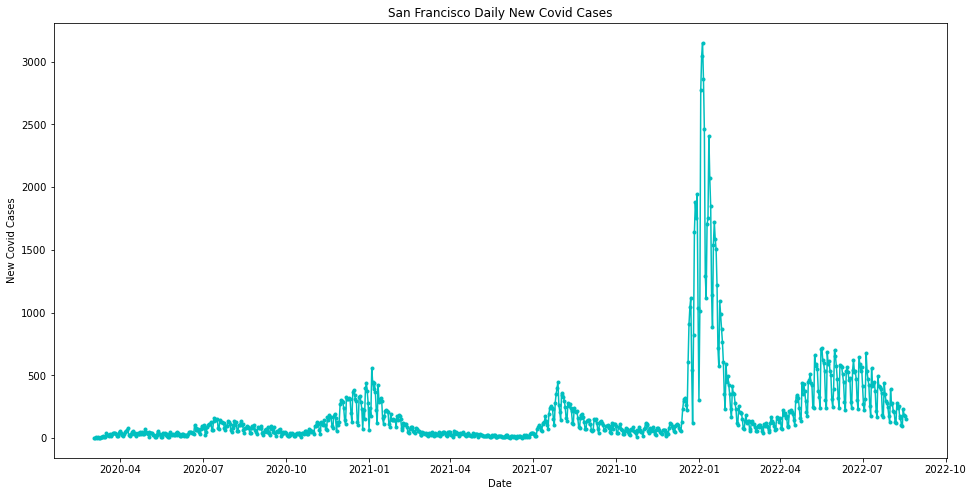

In [13]:
plt.figure(figsize=(16, 8))

plt.xlabel("Date")

plt.ylabel("New Covid Cases")

plt.title('San Francisco Daily New Covid Cases')

plt.plot(df.index, df['New Cases'], color = 'c', marker = '.')

In this plot we can observe the major and minor Covid peaks of the datset. A major peak occured in January 2022.

## **Splitting the dataset**


This dataset covers 899 days, or 2 years and approximately 5.5 months.

We'll consider the data from the **last two months (60 days) as the test data** and the remaining data as the train data.

In [14]:
df_train, df_test = df.iloc[:-60], df.iloc[-60:]

print(df_train.tail())

print(df_test.head())

                          New Cases
Specimen Collection Date           
2022-06-15                      526
2022-06-16                      459
2022-06-17                      481
2022-06-18                      284
2022-06-19                      241
                          New Cases
Specimen Collection Date           
2022-06-20                      539
2022-06-21                      623
2022-06-22                      530
2022-06-23                      531
2022-06-24                      472


The end of the training set goes up until June 19, 2022 and the test set begins with June 20, 2022.

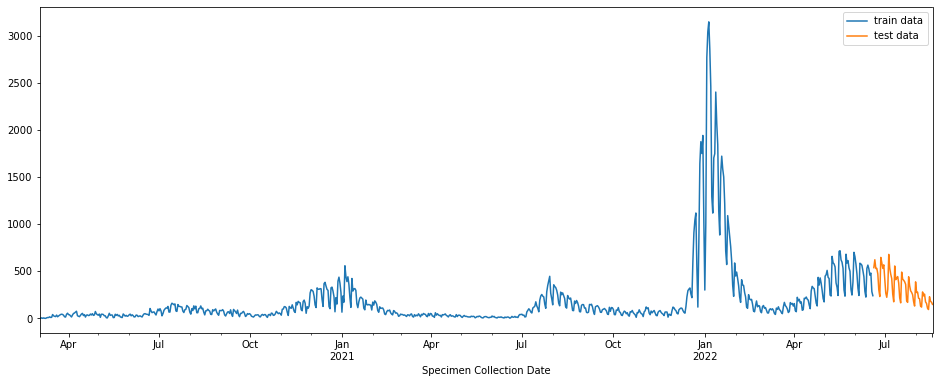

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))

df_train.plot(ax=ax)

df_test.plot(ax=ax)

plt.legend(['train data', 'test data'])

plt.show()

### Checking for stationarity
Now, let us check the rolling mean and standard deviation of the series to visualize if the series has any trend or seasonality.

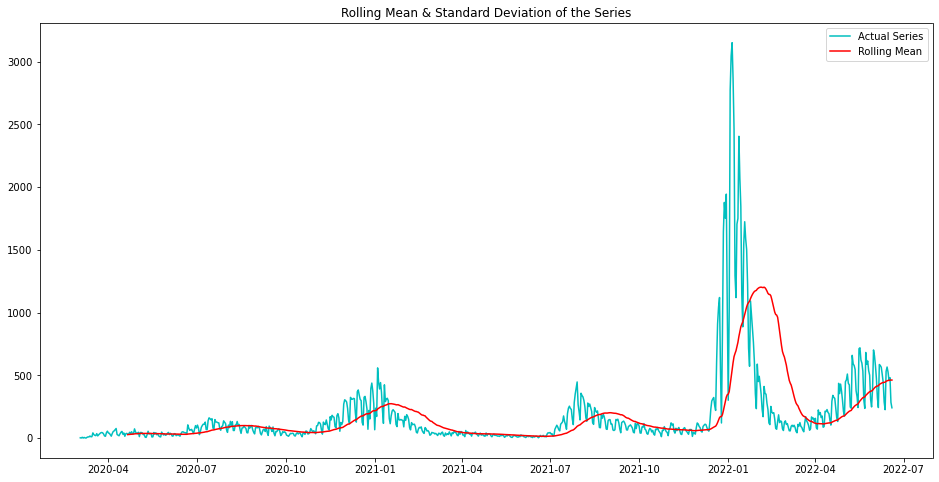

In [16]:
rolmean = df_train.rolling(window = 50).mean()

rolstd = df_train.rolling(window = 50).std()

plt.figure(figsize = (16, 8))

actual = plt.plot(df_train, color = 'c', label = 'Actual Series')

rollingmean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean') 

plt.title('Rolling Mean & Standard Deviation of the Series')

plt.legend()

plt.show()

- We can see that the rolling mean does go up and down, but appears fairly consistent. 
- Since I cannot tell if it is stationary just by looking, let's use the Augmented Dickey-Fuller Test to confirm.

We can also use the Augmented Dickey-Fuller (ADF) Test to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- Null hypothesis: The Time Series is non-stationary
- Alternative hypothesis: The Time Series is stationary

In [17]:
def adfuller(data):
    
    from statsmodels.tsa.stattools import adfuller
    
    print('Dickey-Fuller Test: ')
    
    adftest = adfuller(data['New Cases'])
    
    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])
    
    for key, value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    
    print(adfoutput)

In [18]:
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic           -4.608307
p-value                   0.000125
Lags Used                21.000000
No. of Observations     817.000000
Critical Value (1%)      -3.438379
Critical Value (5%)      -2.865084
Critical Value (10%)     -2.568657
dtype: float64


Observations:
- We can see that the p-value is now far less than 0.05 (for 95% confidence interval), therefore, we can reject the null hypothesis that the series is **non-stationary**.
- We can conclude that the series **is stationary**. 
- Let's decompose the time series to check its different components.

## **Decomposing the time series components into Trend, Seasonality, and Residual**

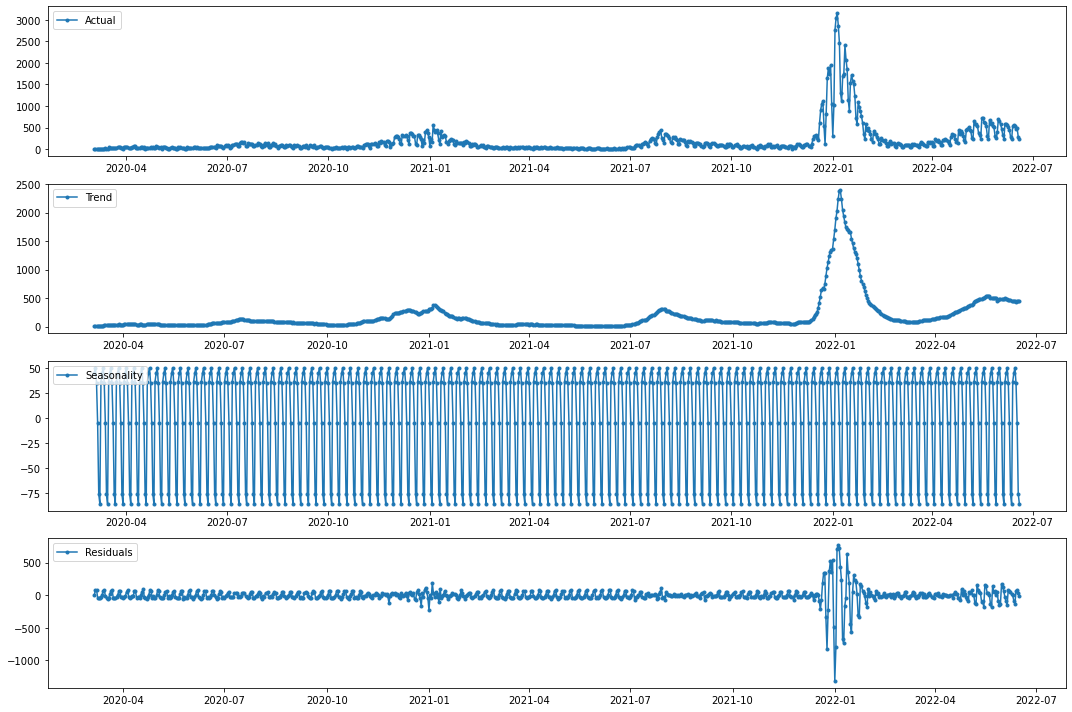

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_train)

trend = decomp.trend

seasonal = decomp.seasonal

residual = decomp.resid

plt.figure(figsize = (15, 10))

plt.subplot(411)
plt.plot(df_train, label = 'Actual', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(412)
plt.plot(trend, label = 'Trend', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(414)
plt.plot(residual, label = 'Residuals', marker = '.')
plt.legend(loc = 'upper left')

plt.tight_layout()

- We can observe the trend component captures the peaks of case spikes, including the last major spike around the beginning of 2022.
- It appears seasonality is capturing the weekly fluctuations in testing.
- Residuals is capturing the noise, and the residuals appear much higher during a peak. This could be because the weekly variation in testing is amplified by the high number of cases observed.

## Baseline Forecasting and Evaluation

To evaluate our models against some sort of baseline we will create a very simple model to compare other models against.

Since our series is stationary, we will use the mean (over the training set) as our baseline.

In [20]:
full_index = pd.concat([df_train, df_test]).index
base_line = np.full(full_index.shape, np.mean(df_train))

predictions = pd.Series(data=base_line, index=full_index)

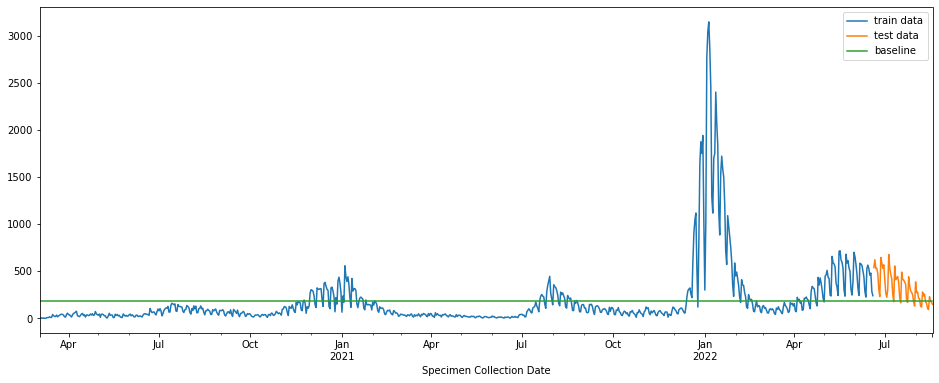

In [21]:
fig, ax = plt.subplots(figsize=(16, 6))

df_train.plot(ax=ax)

df_test.plot(ax=ax)

predictions.plot(ax=ax)

plt.legend(['train data', 'test data', 'baseline'])

plt.show()

In [22]:
predictions

Specimen Collection Date
2020-03-03    183.574493
2020-03-04    183.574493
2020-03-05    183.574493
2020-03-06    183.574493
2020-03-07    183.574493
                 ...    
2022-08-14    183.574493
2022-08-15    183.574493
2022-08-16    183.574493
2022-08-17    183.574493
2022-08-18    183.574493
Length: 899, dtype: float64

In [23]:
df_train

,New Cases
Specimen Collection Date,
2020-03-03,2
2020-03-04,0
2020-03-05,6
2020-03-06,0
2020-03-07,5
...,...
2022-06-15,526
2022-06-16,459
2022-06-17,481


### Root Mean Squared Error

In [24]:
train_error = mean_squared_error(df_train['New Cases'], predictions[:839], squared = False)
train_error

344.84698217241277

In [25]:
test_error = mean_squared_error(df_test['New Cases'], predictions.tail(60), squared = False)
test_error

214.44094427291597

Using this very basic basline model of using the average as the prediction for each day going forward. We see that the train error was larger than the test error. This makes sense when you look at the chart above since cases in the past 60 days have leveled out to around the baseline. 

## ACF and PACF Plots
Now, let's move on to the model building section. First, we will plot the ACF and PACF plots to get the values of p and q, i.e., the order of AR and MA models to be used.

<Figure size 1440x576 with 0 Axes>

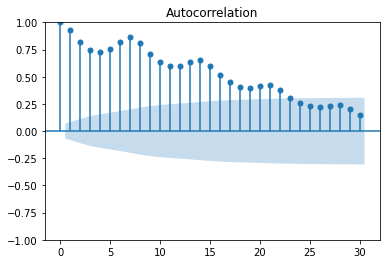

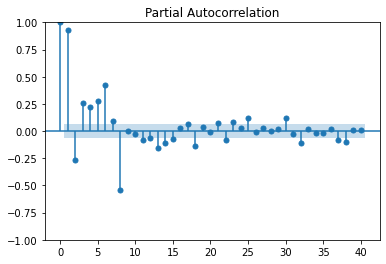

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (20, 8))

plot_acf(df_train, lags = 30) 

plt.show()

plot_pacf(df_train, lags = 40) 

plt.show()

- From the above PACF plot, we observe that the partial autocorrelation is statically significant (outside the blue range) up to 38. p = 38
- Similarly, from the ACF plot, we can infer that q = 22.

## **AR Model**

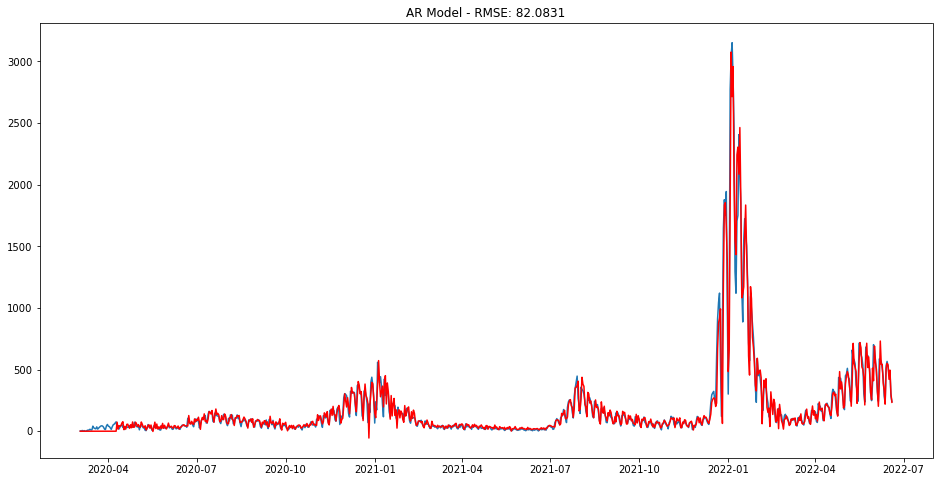

In [27]:
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (16, 8))

model_AR = AutoReg(df_train, lags = 38)

results_AR = model_AR.fit()

plt.plot(df_train)

predict = results_AR.predict(start = 0, end = len(df_train) - 1)

predict = predict.fillna(0)

plt.plot(predict, color = 'red')

plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict, df_train['New Cases'], squared = False))

plt.show()

- We can see that by using the AR model, we get root mean squared error (RMSE) = 82.08.
- This corresponds to being off by 82 cases a day on average. 
- That is not too bad given the high variance in the more recent data. Which, visually, it appears to fit very well.

**Let's check the AIC value** of the model.

In [28]:
results_AR.aic

9445.703443376628

## **MA Model**

- We will be using an ARIMA model with p = 0 and d = 0 so that it works as an MA model.
- q = 22 as we observed from the autocorrelation plot.

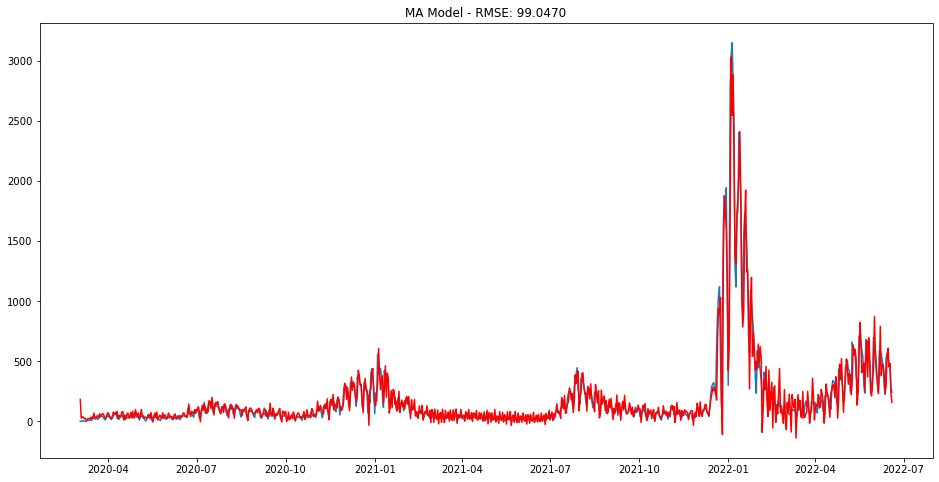

In [29]:
plt.figure(figsize = (16, 8))

model_MA = ARIMA(df_train, order = (0, 0, 22))

results_MA = model_MA.fit()

plt.plot(df_train)

plt.plot(results_MA.fittedvalues, color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues, df_train['New Cases'], squared = False))

plt.show()

- The MA model is giving a higher RMSE when compared to the AR model.

Let's check the AIC value of the model.

In [30]:
results_MA.aic

10162.830457780794

- **The MA model is giving a much higher AIC** when compared to the AR model, AIC penalizes model complexity which is likely contributing to this value. At this point, the AR model is performing better due to the lower RMSE and much lower AIC value.

## **ARMA Model**

We will be using an **ARIMA model with p = 38 and q = 22** (as observed from the ACF and PACF plots) **and d = 0 so that it works as an ARMA model.**

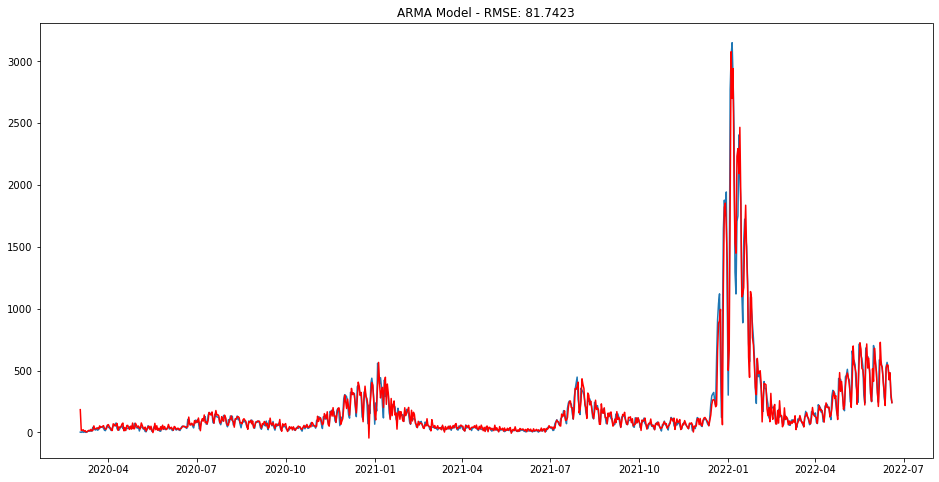

In [31]:
plt.figure(figsize = (16, 8))

model_ARMA = ARIMA(df_train, order = (38, 0, 22))

results_ARMA = model_ARMA.fit()

plt.plot(df_train)

plt.plot(results_ARMA.fittedvalues, color = 'red')

plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_train['New Cases'], squared = False))

plt.show()

The ARMA model is giving a lower RMSE in comparison to AR and MA models.

Let's check the AIC value of the model.

In [32]:
results_ARMA.aic

9903.687454331088

The AIC value is slightly higher than the AR model, but the RMSE is slightly lower.
Let us try using the ARIMA model.

### Additional Model - Auto ARIMA

Using the following code we will find the best ARIMA model.

In [33]:
#pip install pmdarima

In [34]:
import pmdarima as pm

auto_arima_model = pm.auto_arima(df_train, d=None, m=1, seasonal=False, trace=True, 
                                 error_action='ignore', suppress_warnings=True, )
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10208.292, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10579.169, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10540.794, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10516.515, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10577.174, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10416.320, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10340.537, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10210.255, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10345.965, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10515.126, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10352.896, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10318.913, Time=0.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10344.336, Time=0.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=10206.335, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0

We see the AIC values are in the 10,000 range, similar to the MA models. We will select the AR Model and the ARMA model for predictions and compare the results.


# Model Performance Comparission: AR Model and ARMA Model

## AR Model

Now that we have fitted values using the models, because we didn't perform any transformations on the original training data, such as log or shift, we don't need to do any additional transformations.

In [35]:
predictions_AR = pd.Series(results_AR.fittedvalues)
predictions_AR

Specimen Collection Date
2020-04-10     73.155085
2020-04-11     16.968898
2020-04-12     45.037352
2020-04-13     40.873228
2020-04-14     44.903577
                 ...    
2022-06-15    537.345865
2022-06-16    420.794678
2022-06-17    495.417746
2022-06-18    302.375013
2022-06-19    234.242244
Length: 801, dtype: float64

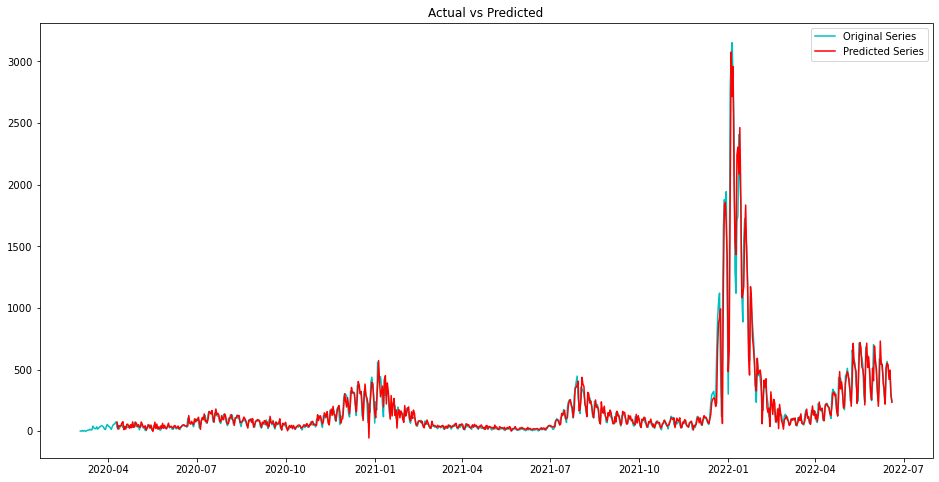

In [36]:
plt.figure(figsize = (16, 8))

plt.plot(df_train, color = 'c', label = 'Original Series')

plt.plot(predictions_AR, color = 'r', label = 'Predicted Series')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

In [37]:
forecasted_AR = results_AR.forecast(steps = 60)

forecasted_AR.head()

2022-06-20    427.704347
2022-06-21    482.863635
2022-06-22    457.685836
2022-06-23    452.340090
2022-06-24    365.703640
Freq: D, dtype: float64

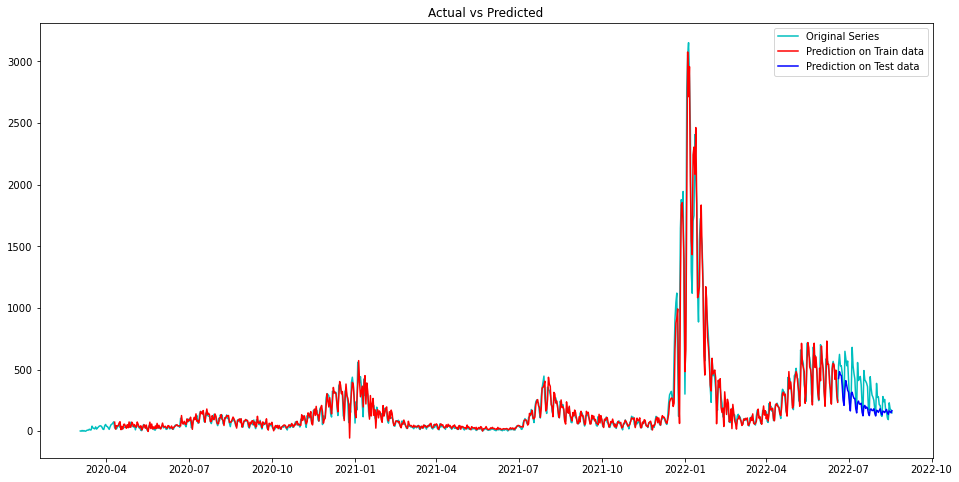

In [38]:
plt.figure(figsize = (16, 8))

plt.plot(df, color = 'c', label = 'Original Series')

plt.plot(predictions_AR, color = 'r', label = 'Prediction on Train data')

plt.plot(forecasted_AR, label = 'Prediction on Test data', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**

- **As observed earlier, most of the predicted values on the training data are close to the actual values**
- **On the test data, the model is performing okay, but with lower estimations than real world values**, as we can see that the blue line appears to generally within low range of the variance on the actual values (cyan blue).
- while it is doing an okay job prediciting the most recent values it doesn't appear that it will capture an upcoming spike if the cases continue to rise.

### Calculating Root Mean Squared Error

In [39]:
train_error_AR = mean_squared_error(predictions_AR, df_train.iloc[:-38], squared = False)

train_error_AR

479.09272351494945

In [40]:
test_error_AR = mean_squared_error(forecasted_AR, df_test, squared = False)

test_error_AR

147.16519895246188

## ARMA Model

In [41]:
predictions_ARMA = pd.Series(results_ARMA.fittedvalues)
predictions_ARMA

Specimen Collection Date
2020-03-03    183.574471
2020-03-04     15.698720
2020-03-05     16.919084
2020-03-06     20.903456
2020-03-07      8.018298
                 ...    
2022-06-15    542.294197
2022-06-16    424.544527
2022-06-17    481.660770
2022-06-18    311.828631
2022-06-19    240.172310
Length: 839, dtype: float64

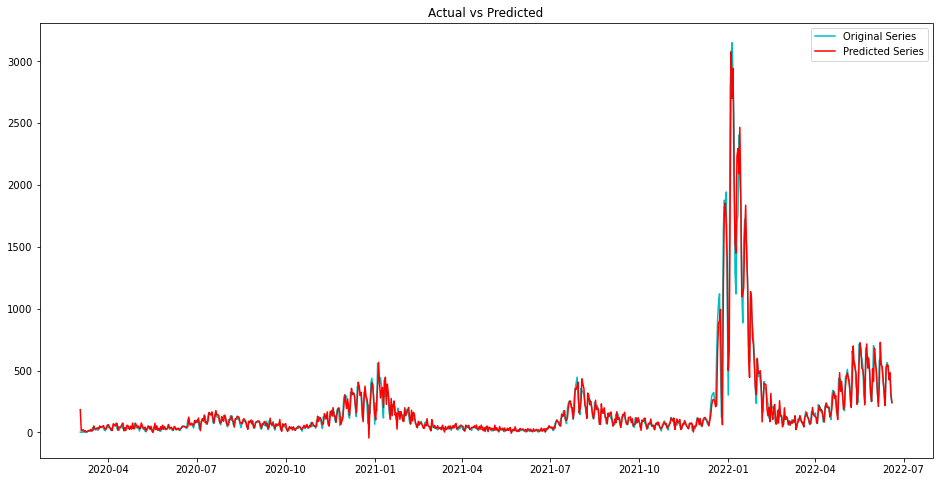

In [42]:
plt.figure(figsize = (16, 8))

plt.plot(df_train, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

In [43]:
forecasted_ARMA = results_ARMA.forecast(steps = 60)

forecasted_ARMA.head()

2022-06-20    424.129397
2022-06-21    473.449659
2022-06-22    456.452430
2022-06-23    429.504432
2022-06-24    359.163619
Freq: D, Name: predicted_mean, dtype: float64

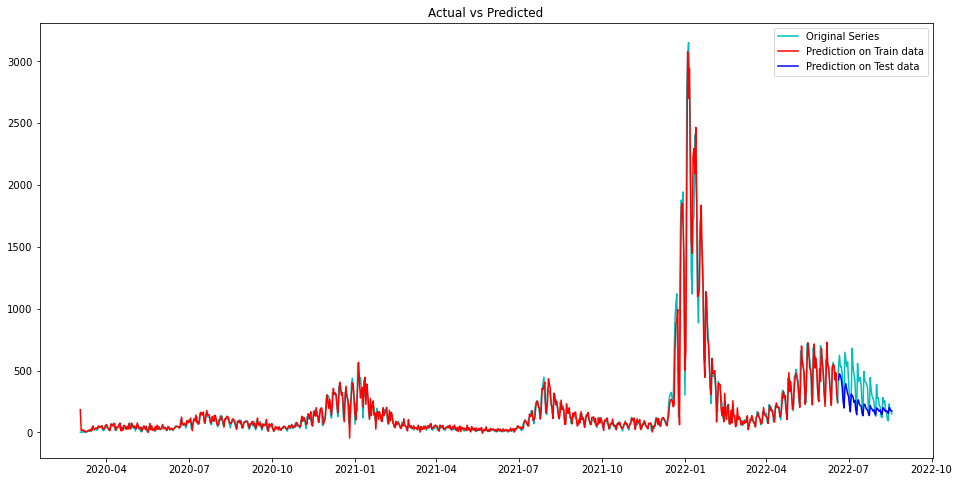

In [44]:
plt.figure(figsize = (16, 8))

plt.plot(df, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Prediction on Train data')

plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**

- The ARMA model appears to be predicting almost exactly the same as the AR model. 
- Let's see how this model compares in terms of RMSE.

### Calculating Root Mean Squared Error

In [45]:
train_error_ARMA = mean_squared_error(predictions_ARMA, df_train, squared = False)

train_error_ARMA

81.74233483105829

In [46]:
test_error_ARMA = mean_squared_error(forecasted_ARMA, df_test, squared = False)

test_error_ARMA

144.29226599794478

## RMSE Table 

In [47]:
# initialize list of lists
data = [['Basline', train_error, test_error], ['AR', train_error_AR, test_error_AR], ['ARMA', train_error_ARMA, test_error_ARMA]]
  
# Create the pandas DataFrame
rmse_table = pd.DataFrame(data, columns=['Model', 'Train Error', 'Test Error'])
  
# print dataframe.
rmse_table


,Model,Train Error,Test Error
0,Basline,344.846982,214.440944
1,AR,479.092724,147.165199
2,ARMA,81.742335,144.292266


## **Conclusion**

- **The best model is ARMA** because it has the lowest test error. 

- **Interestingly, the RMSE is lower on the test data** in comparison to the training data for the baseline and AR models. This implies that the predictions on the test data are closer to the actual values in comparison to the training data. This makes sense because the test data does not contain any major spikes like the training data does. 

- **The RMSE of the test data of the baseline model was 214, so the ARMA model is performing 33% better than our baseline.**


- We can further try to build more complex time series models like SARIMA, SARIMAX, etc., while considering more factors like trend, seasonality, etc. and check if we can get a more generalized model.

In [48]:
#Data export for visualization
df.to_csv('actual_covid_data.csv')
predictions_ARMA.to_csv('predicted_covid_data.csv')
forecasted_ARMA.to_csv('forecasted_covid_data.csv')